In [13]:
import torch
import nltk
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from IPython import display

# An introduction to LSTM

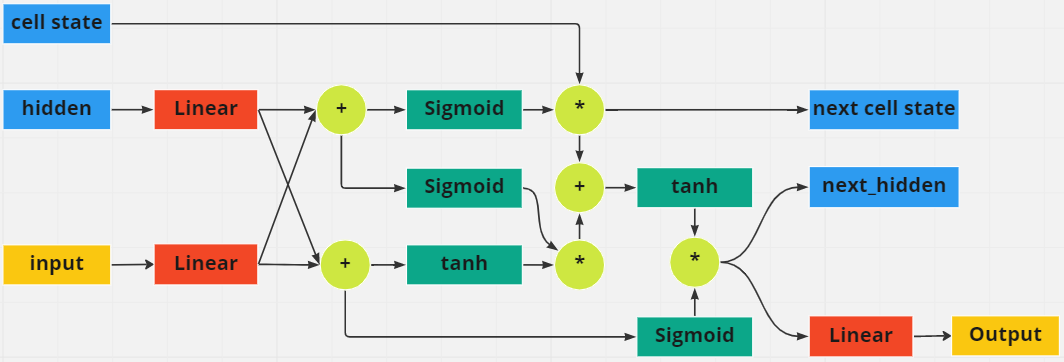

In [3]:
# The architecture of the LSTM is
display.Image('imgs/LSTM_cell.png')

In [5]:
# Just use some short sentence to show how the LSTM embed the sentence
sent = 'How are you today?'
tokens = nltk.word_tokenize(sent)
tokens_dict = {i:t for t, i in enumerate(tokens)}

emb_sent = []
for w in tokens:
    emb_sent.append(torch.tensor(tokens_dict[w], dtype=torch.float32).view(1, -1))
sent_size = len(emb_sent)

inputs = torch.cat(emb_sent).view(sent_size, 1, -1)
print(inputs)
print(inputs.shape)

tensor([[[0.]],

        [[1.]],

        [[2.]],

        [[3.]],

        [[4.]]])
torch.Size([5, 1, 1])


In [8]:
# Set the target tensor for a simple training
target = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32)

In [7]:
# Define parameters
hidden_dim = 10
out_dim = 5
n_layers = 1
batch_size = 1

# Define the LSTM cell 
# Feed the LSTM model with the whole input, thus the input size is 1 = inputs.shape[-1]
lstm = torch.nn.LSTM(inputs.shape[-1], hidden_dim, n_layers, batch_first=True)
linear = torch.nn.Linear(hidden_dim, out_dim)

# Initialize the hidden state and cell state
hidden_state = torch.randn(n_layers, sent_size, hidden_dim) 
cell_state = torch.randn(n_layers, sent_size, hidden_dim)
hidden = (hidden_state, cell_state)

# Feed the sentence to the lstm network
out, hidden = lstm(inputs, hidden)
# out = out.squeeze()[-1, :]
out = linear(out.squeeze()[-1, :])
print(target)
print(out)

tensor([0., 0., 1., 0., 0.])
tensor([ 0.4239,  0.0576, -0.0041, -0.1414, -0.1223], grad_fn=<AddBackward0>)


In [9]:
params = [p for p in lstm.parameters()]
for p in params:
    p.requires_grad = True

n_params = sum(p.nelement() for p in params)
print(f'Total number of parameters {n_params}')

Total number of parameters 520


In [10]:
loss = torch.nn.functional.mse_loss(out, target)
print(f'Loss={loss.item():.4f}')

Loss=0.2453


In [19]:
for i in range(50):
    out, hidden = lstm(inputs, hidden)
    out = linear(out.squeeze()[-1, :])

    loss = torch.nn.functional.mse_loss(out, target)

    # Retain graph to continuously compute the gradient in this case
    for p in params:
        p.grad = None
    loss.backward(retain_graph=True)

    for p in params:
        p.data += -0.05 * p.grad

    loss = torch.nn.functional.mse_loss(out, target)
    print(f'{i+1}/{20}: Loss={loss.item():.4f}')

1/20: Loss=0.0523
2/20: Loss=0.0514
3/20: Loss=0.0508
4/20: Loss=0.0503
5/20: Loss=0.0499
6/20: Loss=0.0496
7/20: Loss=0.0494
8/20: Loss=0.0492
9/20: Loss=0.0490
10/20: Loss=0.0488
11/20: Loss=0.0486
12/20: Loss=0.0485
13/20: Loss=0.0483
14/20: Loss=0.0481
15/20: Loss=0.0480
16/20: Loss=0.0479
17/20: Loss=0.0477
18/20: Loss=0.0476
19/20: Loss=0.0474
20/20: Loss=0.0473
21/20: Loss=0.0472
22/20: Loss=0.0471
23/20: Loss=0.0469
24/20: Loss=0.0468
25/20: Loss=0.0467
26/20: Loss=0.0466
27/20: Loss=0.0465
28/20: Loss=0.0464
29/20: Loss=0.0463
30/20: Loss=0.0462
31/20: Loss=0.0461
32/20: Loss=0.0460
33/20: Loss=0.0459
34/20: Loss=0.0458
35/20: Loss=0.0457
36/20: Loss=0.0457
37/20: Loss=0.0456
38/20: Loss=0.0455
39/20: Loss=0.0454
40/20: Loss=0.0454
41/20: Loss=0.0453
42/20: Loss=0.0452
43/20: Loss=0.0452
44/20: Loss=0.0451
45/20: Loss=0.0450
46/20: Loss=0.0450
47/20: Loss=0.0449
48/20: Loss=0.0449
49/20: Loss=0.0448
50/20: Loss=0.0448


In [20]:
out


tensor([ 0.0468,  0.0342,  0.8794, -0.2880,  0.3506], grad_fn=<AddBackward0>)

# An example of part-of-tagging from torch

In [24]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [85]:
words = []
tags = []
for s, t in training_data:
    words += s
    tags += t

words = list(set(words))
tags = list(set(tags))

word_to_ix = {w:i for i, w in enumerate(words)}
tag_to_ix = {t:i for i, t in enumerate(tags)}
print(word_to_ix)
print(tag_to_ix)

ix_to_tag = {i:t for t, i in tag_to_ix.items()}

{'The': 0, 'ate': 1, 'that': 2, 'read': 3, 'dog': 4, 'book': 5, 'Everybody': 6, 'the': 7, 'apple': 8}
{'NN': 0, 'DET': 1, 'V': 2}


In [71]:
# define a class for applying the model
class LSTMTagger(nn.Module):

    def __init__(self, emb_dim, hidden_dim, vocab_size, out_dim):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, sent):
        embeds = self.embedding(sent)
        lstm_out, _ = self.lstm(embeds.view(len(sent), 1, -1))
        linear_out = self.linear(lstm_out.view(len(sent), -1))
        tag_score = F.log_softmax(linear_out, dim=1)
        return tag_score

In [72]:
EMBEDDING_DIM = 10
HIDDEN_DIM = 20
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [73]:
with torch.no_grad():
    sent = training_data[0][0] # Get the first sentence (an list of words)
    inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) # Encode
    print(model(inputs)) # Get the tag score without training 

tensor([[-1.0042, -1.3323, -0.9948],
        [-1.0288, -1.3185, -0.9807],
        [-1.0429, -1.3317, -0.9584],
        [-1.0298, -1.3475, -0.9597],
        [-1.0978, -1.3416, -0.9039]])


In [74]:
MAX_EPOCH = 200
for i in range(MAX_EPOCH):
    print(f'{i+1}/{MAX_EPOCH}:=====================')
    for sent, tag in training_data:
        loss = 0
        model.zero_grad()

        inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long)
        targets = torch.tensor([tag_to_ix[w] for w in tag], dtype=torch.long)
        # print(targets)

        tag_scores = model(inputs)
        # print(tag_scores)


        loss = loss_function(tag_scores, targets)

        loss.backward()

        optimizer.step()
    
        print(f'Loss={loss.item()}')
    
    print()

1/200:=====================
Loss=1.1529731750488281
Loss=1.0566563606262207
2/200:=====================
Loss=1.1423951387405396
Loss=1.0445669889450073
3/200:=====================
Loss=1.1329925060272217
Loss=1.0333558320999146
4/200:=====================
Loss=1.1245616674423218
Loss=1.022849678993225
5/200:=====================
Loss=1.116934895515442
Loss=1.0129051208496094
6/200:=====================
Loss=1.1099720001220703
Loss=1.0034031867980957
7/200:=====================
Loss=1.1035559177398682
Loss=0.9942446351051331
8/200:=====================
Loss=1.097588300704956
Loss=0.9853461384773254
9/200:=====================
Loss=1.0919862985610962
Loss=0.976637601852417
10/200:=====================
Loss=1.0866785049438477
Loss=0.9680602550506592
11/200:=====================
Loss=1.0816047191619873
Loss=0.9595636129379272
12/200:=====================
Loss=1.0767128467559814
Loss=0.9511055946350098
13/200:=====================
Loss=1.071958303451538
Loss=0.9426500201225281
14/200:======

In [86]:
sample = training_data[1]
sent = sample[0]
tags = sample[1]

inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) 
pred_seq = model(inputs).argmax(1).tolist()
pred = [ix_to_tag[i] for i in pred_seq]

print(sample[1])
print(pred)

['NN', 'V', 'DET', 'NN']
['NN', 'V', 'DET', 'NN']
